# DeepBridge Tutorial - Part 3: Comparing Distillation Methods

This notebook continues our exploration of the DeepBridge library, focusing on:

1. Comparing multiple distillation methods
2. Analyzing trade-offs between different approaches
3. Visualizing performance metrics

Let's begin by importing the necessary components.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


sys.path.append(os.path.expanduser("~/projetos/DeepBridge"))

# Import DeepBridge components
from deepbridge.core.db_data import DBDataset
from deepbridge.distillation.auto_distiller import AutoDistiller
from deepbridge.distillation.techniques.surrogate import SurrogateModel
from deepbridge.distillation.techniques.knowledge_distillation import KnowledgeDistillation
from deepbridge.utils.model_registry import ModelType

# Configure plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Prepare Dataset

We'll use the breast cancer dataset from scikit-learn as our example. First, we'll load the data and create a teacher model.

In [5]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of classes: {len(np.unique(y))}")

Data shape: (569, 30)
Number of features: 30
Number of samples: 569
Number of classes: 2


## 2. Train a Teacher Model

We'll use a Random Forest classifier as our teacher model. This will be a complex model with good performance but may be difficult to deploy in resource-constrained environments.

In [6]:
# Create and train a Random Forest as the teacher model
teacher_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
teacher_model.fit(X_train, y_train)

# Evaluate the teacher model
train_accuracy = teacher_model.score(X_train, y_train)
test_accuracy = teacher_model.score(X_test, y_test)

print(f"Teacher model (Random Forest) training accuracy: {train_accuracy:.4f}")
print(f"Teacher model (Random Forest) test accuracy: {test_accuracy:.4f}")

# Get teacher's predictions
teacher_probs_train = teacher_model.predict_proba(X_train)
teacher_probs_test = teacher_model.predict_proba(X_test)

Teacher model (Random Forest) training accuracy: 1.0000
Teacher model (Random Forest) test accuracy: 0.9649


## 3. Prepare DeepBridge Dataset

Now, we'll create a DBDataset object which is the standard data container for DeepBridge.

In [7]:
# Create probability DataFrames
train_probs_df = pd.DataFrame(teacher_probs_train, columns=['prob_class_0', 'prob_class_1'])
test_probs_df = pd.DataFrame(teacher_probs_test, columns=['prob_class_0', 'prob_class_1'])

# Combine with original data for DeepBridge dataset
train_data = X_train.copy()
train_data['target'] = y_train.values

test_data = X_test.copy()
test_data['target'] = y_test.values

# Create the DBDataset
db_dataset = DBDataset(
    train_data=train_data,
    test_data=test_data,
    target_column='target',
    train_predictions=train_probs_df,
    test_predictions=test_probs_df,
    prob_cols=['prob_class_0', 'prob_class_1']
)

print(db_dataset)

DBDataset(with 569 samples (not split))
Features: 30 total (0 categorical, 30 numerical)
Target: 'target'
Model: not loaded
Predictions: available


## 4. Compare Different Distillation Methods

We'll compare the two main distillation methods supported by DeepBridge:
1. Surrogate Model
2. Knowledge Distillation (with temperature scaling)

We'll use several different student model types and compare their performance.

### 4.1 Method 1: Surrogate Model

The surrogate model approach directly fits a simpler model to the outputs of the teacher model, treating it as a regression problem.

In [9]:
# Run experiments with surrogate method
surrogate_distiller = AutoDistiller(
    dataset=db_dataset,
    output_dir="distillation_results/surrogate",
    test_size=0.2,
    random_state=42,
    n_trials=10
)

# Customize to test different model types
surrogate_distiller.customize_config(
    model_types=[ModelType.LOGISTIC_REGRESSION, ModelType.DECISION_TREE, ModelType.GBM, ModelType.XGB],
    temperatures=[1.0],  # Temperature has minimal effect in surrogate method
    alphas=[0.5],        # Alpha has minimal effect in surrogate method
    distillation_method="surrogate"
)

# Run the distillation process
surrogate_results = surrogate_distiller.run(use_probabilities=True, verbose_output=False)


=== Evaluating distillation model on train dataset ===
Student predictions shape: (455, 2)
First 3 student probabilities: [[9.98973846e-05 9.99900103e-01]
 [1.08242035e-04 9.99891758e-01]
 [1.04069710e-04 9.99895930e-01]]
Teacher probabilities type: <class 'pandas.core.frame.DataFrame'>
Using 'prob_class_1' column from teacher probabilities
Teacher probabilities shape: (455, 2)
First 3 teacher probabilities (positive class): [1.   0.94 0.94]
KS Statistic calculation: 0.34945054945054943, p-value: 4.807660883741121e-25
R² Score calculation: 0.9486786546733981
Teacher prob type: <class 'numpy.ndarray'>, shape: (455,)
Student prob type: <class 'numpy.ndarray'>, shape: (455,)
Teacher prob first 5 values: [1.   0.94 0.94 0.99 1.  ]
Student prob first 5 values: [0.9999001  0.99989176 0.99989593 0.9999     0.9999018 ]
KS calculation successful: (0.34945054945054943, 4.807660883741121e-25)
Sorted teacher dist - min: 0.0, max: 1.0, length: 455
Sorted student dist - min: 9.170030534733087e-05, 

### 4.2 Method 2: Knowledge Distillation

The knowledge distillation approach uses temperature scaling and balances between matching the teacher's outputs and the true labels.

In [10]:
# Run experiments with knowledge distillation method
kd_distiller = AutoDistiller(
    dataset=db_dataset,
    output_dir="distillation_results/knowledge_distillation",
    test_size=0.2,
    random_state=42,
    n_trials=10
)

# Customize to test different hyperparameters
kd_distiller.customize_config(
    model_types=[ModelType.LOGISTIC_REGRESSION, ModelType.DECISION_TREE, ModelType.GBM, ModelType.XGB],
    temperatures=[0.5, 1.0, 2.0],  # Test different temperature values
    alphas=[0.3, 0.5, 0.7],        # Test different alpha values
    distillation_method="knowledge_distillation"
)

# Run the distillation process
kd_results = kd_distiller.run(use_probabilities=True, verbose_output=False)


=== Evaluating distillation model on train dataset ===
Student predictions shape: (455, 2)
First 3 student probabilities: [[9.98973846e-05 9.99900103e-01]
 [1.08242035e-04 9.99891758e-01]
 [1.04069710e-04 9.99895930e-01]]
Teacher probabilities type: <class 'pandas.core.frame.DataFrame'>
Using 'prob_class_1' column from teacher probabilities
Teacher probabilities shape: (455, 2)
First 3 teacher probabilities (positive class): [1.   0.94 0.94]
KS Statistic calculation: 0.34945054945054943, p-value: 4.807660883741121e-25
R² Score calculation: 0.9486786546733981
Teacher prob type: <class 'numpy.ndarray'>, shape: (455,)
Student prob type: <class 'numpy.ndarray'>, shape: (455,)
Teacher prob first 5 values: [1.   0.94 0.94 0.99 1.  ]
Student prob first 5 values: [0.9999001  0.99989176 0.99989593 0.9999     0.9999018 ]
KS calculation successful: (0.34945054945054943, 4.807660883741121e-25)
Sorted teacher dist - min: 0.0, max: 1.0, length: 455
Sorted student dist - min: 9.170030534733087e-05, 

/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

## 5. Analyze Results

Now let's analyze the results of the two methods and see how they compare. We'll look at:
1. Best model from each method
2. Distribution metrics (KL divergence, KS statistic, R² score)
3. Classification performance metrics

In [11]:
# Find the best models from each method
surrogate_best = surrogate_distiller.find_best_model(metric='test_accuracy')
kd_best = kd_distiller.find_best_model(metric='test_accuracy')

# Print summary information
print("===== Best Surrogate Model =====")
print(f"Model Type: {surrogate_best['model_type']}")
print(f"Accuracy: {surrogate_best.get('test_accuracy', 'N/A'):.4f}")
print(f"KL Divergence: {surrogate_best.get('test_kl_divergence', 'N/A'):.4f}")
print(f"KS Statistic: {surrogate_best.get('test_ks_statistic', 'N/A'):.4f}")
print(f"R² Score: {surrogate_best.get('test_r2_score', 'N/A'):.4f}")

print("\n===== Best Knowledge Distillation Model =====")
print(f"Model Type: {kd_best['model_type']}")
print(f"Temperature: {kd_best['temperature']}")
print(f"Alpha: {kd_best['alpha']}")
print(f"Accuracy: {kd_best.get('test_accuracy', 'N/A'):.4f}")
print(f"KL Divergence: {kd_best.get('test_kl_divergence', 'N/A'):.4f}")
print(f"KS Statistic: {kd_best.get('test_ks_statistic', 'N/A'):.4f}")
print(f"R² Score: {kd_best.get('test_r2_score', 'N/A'):.4f}")

===== Best Surrogate Model =====
Model Type: ModelType.DECISION_TREE
Accuracy: 0.9386
KL Divergence: 0.5370
KS Statistic: 0.3246
R² Score: 0.8895

===== Best Knowledge Distillation Model =====
Model Type: ModelType.GBM
Temperature: 1.0
Alpha: 0.3
Accuracy: 0.9912
KL Divergence: 0.0395
KS Statistic: 0.4561
R² Score: 0.9818


## 6. Trade-off Between Accuracy and Distribution Preservation

Finally, let's visualize the trade-off between classification accuracy and preserving the teacher's probability distribution.

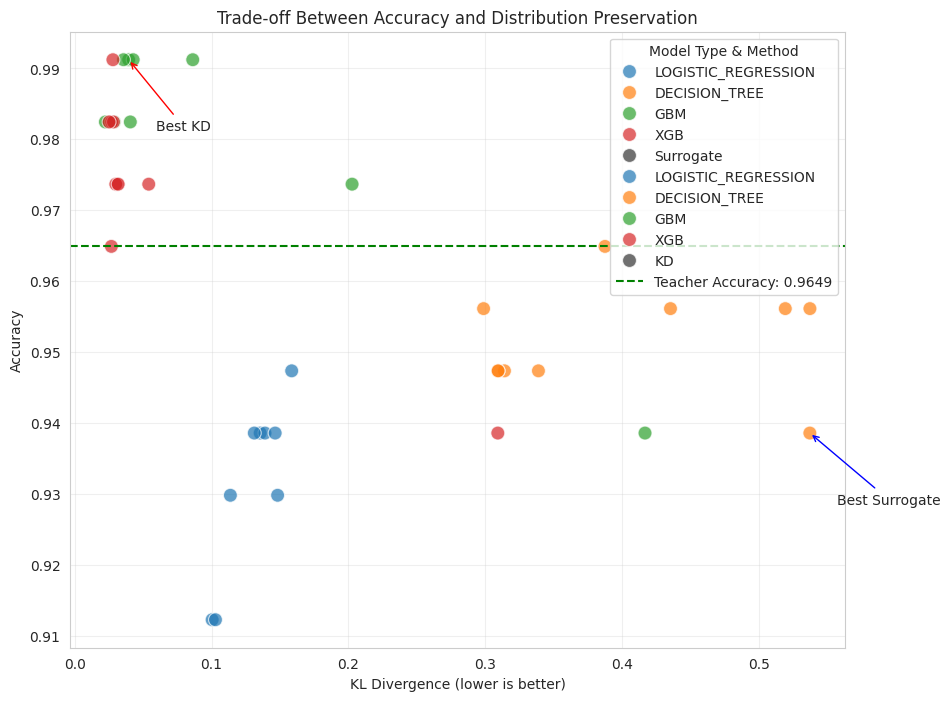

In [14]:
# Create scatter plot showing trade-off between accuracy and KL divergence
plt.figure(figsize=(10, 8))

# Create scatter plot for surrogate method
sns.scatterplot(
    x='test_kl_divergence', 
    y='test_accuracy', 
    hue='model_type',
    style=['Surrogate'] * len(surrogate_results),
    s=100,
    alpha=0.7,
    data=surrogate_results.assign(method='Surrogate')
)

# Create scatter plot for knowledge distillation method
sns.scatterplot(
    x='test_kl_divergence', 
    y='test_accuracy', 
    hue='model_type',
    style=['KD'] * len(kd_results),
    s=100,
    alpha=0.7,
    data=kd_results.assign(method='KD')
)

# Add annotations for the best models
plt.annotate('Best Surrogate', 
             xy=(surrogate_best['test_kl_divergence'], surrogate_best['test_accuracy']),
             xytext=(surrogate_best['test_kl_divergence']+0.02, surrogate_best['test_accuracy']-0.01),
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.annotate('Best KD', 
             xy=(kd_best['test_kl_divergence'], kd_best['test_accuracy']),
             xytext=(kd_best['test_kl_divergence']+0.02, kd_best['test_accuracy']-0.01),
             arrowprops=dict(arrowstyle='->', color='red'))

# Add reference line for teacher model accuracy
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Teacher Accuracy: {test_accuracy:.4f}')

plt.title('Trade-off Between Accuracy and Distribution Preservation')
plt.xlabel('KL Divergence (lower is better)')
plt.ylabel('Accuracy')
plt.legend(title='Model Type & Method')
plt.grid(True, alpha=0.3)
plt.show()

## 9. Discussion and Conclusion

Based on our experiments, we can draw several conclusions about the two distillation methods:

1. **Surrogate Method vs. Knowledge Distillation**:
   - The surrogate method is simpler and directly fits a model to match the teacher's outputs.
   - Knowledge distillation offers more flexibility through temperature scaling and alpha balancing.

2. **Effect of Temperature**:
   - Higher temperatures "soften" probability distributions, emphasizing the relationships between classes.
   - Lower temperatures make distributions more peaked, focusing on the most likely class.

3. **Effect of Alpha**:
   - Higher alpha values prioritize matching the teacher's distributions.
   - Lower alpha values give more weight to predicting the correct hard labels.

4. **Trade-offs**:
   - There is often a trade-off between accuracy and distribution preservation.
   - Some models achieve better distribution matching (lower KL divergence) at the expense of accuracy.
   - The best choice depends on your specific requirements - whether you need accurate class predictions or well-calibrated probabilities.

5. **Model Selection**:
   - Simpler models like Logistic Regression can perform well when distilled properly.
   - GBM and XGBoost often provide the best balance of accuracy and distribution matching.
   - The optimal model choice depends on your deployment constraints and requirements.

In summary, DeepBridge offers powerful tools for model distillation, allowing you to convert complex models into simpler ones with good performance and well-calibrated probabilities. The choice between distillation methods should be guided by your specific needs regarding model size, inference speed, and the importance of well-calibrated probabilities.

## 10. Further Steps

Here are some additional experiments you might want to try:

1. Analyze model size and inference speed of the distilled models
2. Try distillation with more diverse student model architectures
3. Apply ensemble distillation when you have multiple teacher models
4. Combine distillation with quantization and pruning for even more compact models
5. Experiment with advanced visualization techniques from DeepBridge's visualization module